In [1]:
import IPython.core.display
IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

# Used modules

In [2]:
import os, glob, copy, signal, time

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.utils.data
import torchvision

# Data

In [3]:
dirpath = '/data/datasets/carvana/'
reduce_factor = 4
split_ratio = .8
batch_size = 75
num_workers = 20

In [4]:
class DatasetCarvana(torch.utils.data.Dataset):
    def __init__(self, dirpath, transform=None, split_ratio=None, train=None, reduce_factor=None):
        super().__init__()
        self.transform = transform
        self.reduce_factor = reduce_factor
        pattern_filepath_inp = os.path.join(dirpath, 'train_hq/*')
        pattern_filepath_out = os.path.join(dirpath, 'train_masks/*')
        self.l_fp_inp = sorted([fp for fp in glob.glob(pathname=pattern_filepath_inp) if fp[-4:].lower() == '.jpg'])
        self.l_fp_out = sorted([fp for fp in glob.glob(pathname=pattern_filepath_out) if fp[-4:].lower() == '.gif'])
        assert len(self.l_fp_inp) == len(self.l_fp_out), 'List of input filepaths of different size of that of output filepaths'
        for fp_inp, fp_out in zip(self.l_fp_inp, self.l_fp_out):
            label_inp, label_out = os.path.basename(fp_inp), os.path.basename(fp_out).replace('_mask', '')
            assert label_inp[:-4] == label_out[:-4], 'Different filename label for the pair {} and {}'.format(label_inp, label_out)
        assert (split_ratio == train == None) or (split_ratio is not None and train is not None), 'Both "train" and "split_ratio" must be both either defined or undefined.'
        assert train == None or train == True or train == False, '"train" must be either "None", "True", or "False".'
        n_limit = None
        self.l_fp_inp = self.l_fp_inp[:n_limit]
        self.l_fp_out = self.l_fp_out[:n_limit]
        if split_ratio is not None:
            assert type(split_ratio) == float, '"split_ratio" must be a float.'
            n = int(np.round(len(self.l_fp_inp) * split_ratio))
            if train == True:
                self.l_fp_inp = self.l_fp_inp[:n]
                self.l_fp_out= self.l_fp_out[:n]
            elif train == False:
                self.l_fp_inp = self.l_fp_inp[n:]              
                self.l_fp_out = self.l_fp_out[n:]              
    def __len__(self):
        return len(self.l_fp_inp)
    def __getitem__(self, idx):
        x, y = PIL.Image.open(self.l_fp_inp[idx]), PIL.Image.open(self.l_fp_out[idx])
        if self.reduce_factor is not None:
            size_new = (np.array(x.size) / self.reduce_factor).astype(int).tolist()
            x = x.resize(size=size_new, resample=PIL.Image.BILINEAR)
            y = y.resize(size=size_new, resample=PIL.Image.BILINEAR)
        if self.transform is not None:
            x = self.transform(x)
            y = np.array(y, dtype=np.float32)
            y = torch.FloatTensor(y).unsqueeze(0)
        return x, y

5088


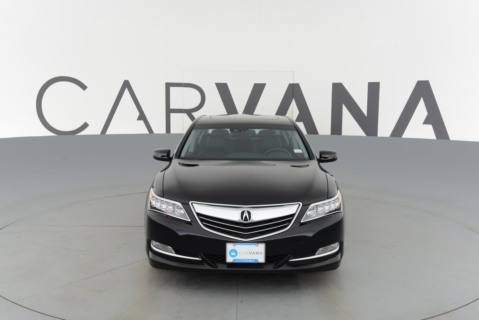

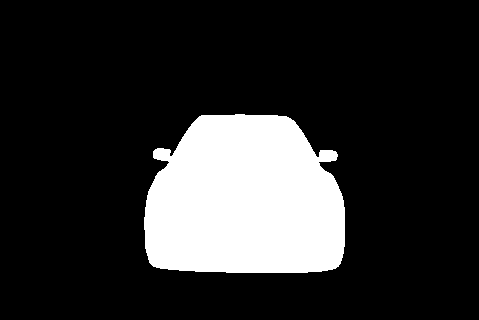

In [5]:
ds_show = DatasetCarvana(dirpath=dirpath, reduce_factor=reduce_factor)
print(len(ds_show))
x, y = ds_show[0]
IPython.core.display.display(x)
IPython.core.display.display(y)

In [6]:
ds_train = DatasetCarvana(dirpath=dirpath, reduce_factor=reduce_factor, transform=torchvision.transforms.ToTensor(), split_ratio=split_ratio, train=True)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
ds_valid = DatasetCarvana(dirpath=dirpath, reduce_factor=reduce_factor, transform=torchvision.transforms.ToTensor(), split_ratio=split_ratio, train=False)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [7]:
for ds, dl in zip([ds_train, ds_valid], [dl_train, dl_valid]):
    print(len(ds))
    x, y = ds[3]
    print(type(x), x.shape)
    print(type(y), y.shape)
    x, y = next(iter(dl))
    print(type(x), x.shape)
    print(type(y), y.shape)

4070
<class 'torch.FloatTensor'> torch.Size([3, 320, 479])
<class 'torch.FloatTensor'> torch.Size([1, 320, 479])
<class 'torch.FloatTensor'> torch.Size([75, 3, 320, 479])
<class 'torch.FloatTensor'> torch.Size([75, 1, 320, 479])
1018
<class 'torch.FloatTensor'> torch.Size([3, 320, 479])
<class 'torch.FloatTensor'> torch.Size([1, 320, 479])
<class 'torch.FloatTensor'> torch.Size([75, 3, 320, 479])
<class 'torch.FloatTensor'> torch.Size([75, 1, 320, 479])


# Model

## U-Net + Dilated Convolutions
<img src="../figures/network.png" alt="U-Net + Dilated Convolutions" style="width: 50%;"/>


## Dilated Convolution
<img src="../figures/dilated_convolution.png" alt="Dilated Convolution" style="width: 50%;"/>

In [8]:
h, l = x.size(2), x.size(3)
l_sizes = list()
for idx_mxpl in [2 ** i for i in range(4)]:
    l_sizes.append((h // idx_mxpl, l // idx_mxpl))
print('l_sizes: {}'.format(l_sizes))

l_sizes: [(320, 479), (160, 239), (80, 119), (40, 59)]


In [9]:
class Model03(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.drop50 = torch.nn.Dropout2d(p=.5, inplace=True)
        self.mxpl22 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.upsm01 = torch.nn.Upsample(size=l_sizes[2], mode='bilinear')
        self.upsm02 = torch.nn.Upsample(size=l_sizes[1], mode='bilinear')
        self.upsm03 = torch.nn.Upsample(size=l_sizes[0], mode='bilinear')

        out_channels_base = 32
        self.conv01 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=1*out_channels_base, in_channels=3)
        self.conv02 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=1*out_channels_base, in_channels=self.conv01.out_channels)

        self.conv03 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=2*out_channels_base, in_channels=self.conv02.out_channels)
        self.conv04 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=2*out_channels_base, in_channels=self.conv03.out_channels)

        self.conv05 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=4*out_channels_base, in_channels=self.conv04.out_channels)
        self.conv06 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=4*out_channels_base, in_channels=self.conv05.out_channels)

        self.conv07 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), dilation=1, out_channels=8*out_channels_base, in_channels=self.conv06.out_channels)
        self.conv08 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(2, 2), dilation=2, out_channels=8*out_channels_base, in_channels=self.conv07.out_channels)
        self.conv09 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(4, 4), dilation=4, out_channels=8*out_channels_base, in_channels=self.conv08.out_channels)
        self.conv10 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(8, 8), dilation=8, out_channels=8*out_channels_base, in_channels=self.conv09.out_channels)
        self.conv11 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(16, 16), dilation=16, out_channels=8*out_channels_base, in_channels=self.conv10.out_channels)
        self.conv12 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(32, 32), dilation=32, out_channels=8*out_channels_base, in_channels=self.conv11.out_channels)

        self.conv13 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=4*out_channels_base, in_channels=self.conv12.out_channels)
        self.conv14 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=4*out_channels_base, in_channels=self.conv06.out_channels + self.conv13.out_channels)
        self.conv15 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=4*out_channels_base, in_channels=self.conv14.out_channels)

        self.conv16 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=2*out_channels_base, in_channels=self.conv15.out_channels)
        self.conv17 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=2*out_channels_base, in_channels=self.conv04.out_channels + self.conv16.out_channels)
        self.conv18 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=2*out_channels_base, in_channels=self.conv17.out_channels)

        self.conv19 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=1*out_channels_base, in_channels=self.conv18.out_channels)
        self.conv20 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=1*out_channels_base, in_channels=self.conv02.out_channels + self.conv19.out_channels)
        self.conv21 = torch.nn.Conv2d(kernel_size=(3, 3), padding=(1, 1), out_channels=1*out_channels_base, in_channels=self.conv20.out_channels)

        self.conv22 = torch.nn.Conv2d(kernel_size=(1, 1), out_channels=1, in_channels=self.conv21.out_channels)

    def forward(self, x):
        x = self.conv01(x)
        x = torch.nn.functional.relu(x)
        x = self.conv02(x)
        x1 = torch.nn.functional.relu(x)
        x = self.mxpl22(x1)
        x = self.drop50(x)

        x = self.conv03(x)
        x = torch.nn.functional.relu(x)
        x = self.conv04(x)
        x2 = torch.nn.functional.relu(x)
        x = self.mxpl22(x2)
        x = self.drop50(x)

        x = self.conv05(x)
        x = torch.nn.functional.relu(x)
        x = self.conv06(x)
        x3 = torch.nn.functional.relu(x)
        x = self.mxpl22(x3)
        x = self.drop50(x)

        d1 = torch.nn.functional.relu(self.conv07(x))
        d2 = torch.nn.functional.relu(self.conv08(d1))
        d3 = torch.nn.functional.relu(self.conv09(d2))
        d4 = torch.nn.functional.relu(self.conv10(d3))
        d5 = torch.nn.functional.relu(self.conv11(d4))
        d6 = torch.nn.functional.relu(self.conv12(d5))
        x = d1 + d2 + d3 + d4 + d5 + d6
        x = self.drop50(x)

        x = self.upsm01(x)
        x = self.conv13(x)
        x = torch.nn.functional.relu(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv14(x)
        x = torch.nn.functional.relu(x)
        x = self.conv15(x)
        x = torch.nn.functional.relu(x)
        x = self.drop50(x)

        x = self.upsm02(x)
        x = self.conv16(x)
        x = torch.nn.functional.relu(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv17(x)
        x = torch.nn.functional.relu(x)
        x = self.conv18(x)
        x = torch.nn.functional.relu(x)
        x = self.drop50(x)

        x = self.upsm03(x)
        x = self.conv19(x)
        x = torch.nn.functional.relu(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv20(x)
        x = torch.nn.functional.relu(x)
        x = self.conv21(x)
        x = torch.nn.functional.relu(x)
        x = self.drop50(x)

        x = self.conv22(x)
        x = torch.nn.functional.sigmoid(x)

        return x

model = Model03()
model = torch.nn.DataParallel(model)
# if torch.cuda.is_available() and False:
#     print('cuda')
#     model = model.cuda()

# Training

## Training settings

In [10]:
n_epochs = 1000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1.e-4)
def dice(o_data, y_data):
    r_data = torch.round(o_data)
    return 2 * (r_data * y_data).sum() / (r_data.sum() + y_data.sum())

In [15]:
!cp ../../../yugo4k/git/robertoalotufo/models/carvana* /data/models/

## History

['l_epochs_train', 'l_epochs_valid', 'l_loss_train', 'l_loss_valid', 'l_accr_train', 'l_accr_valid', 'l_elapsed']


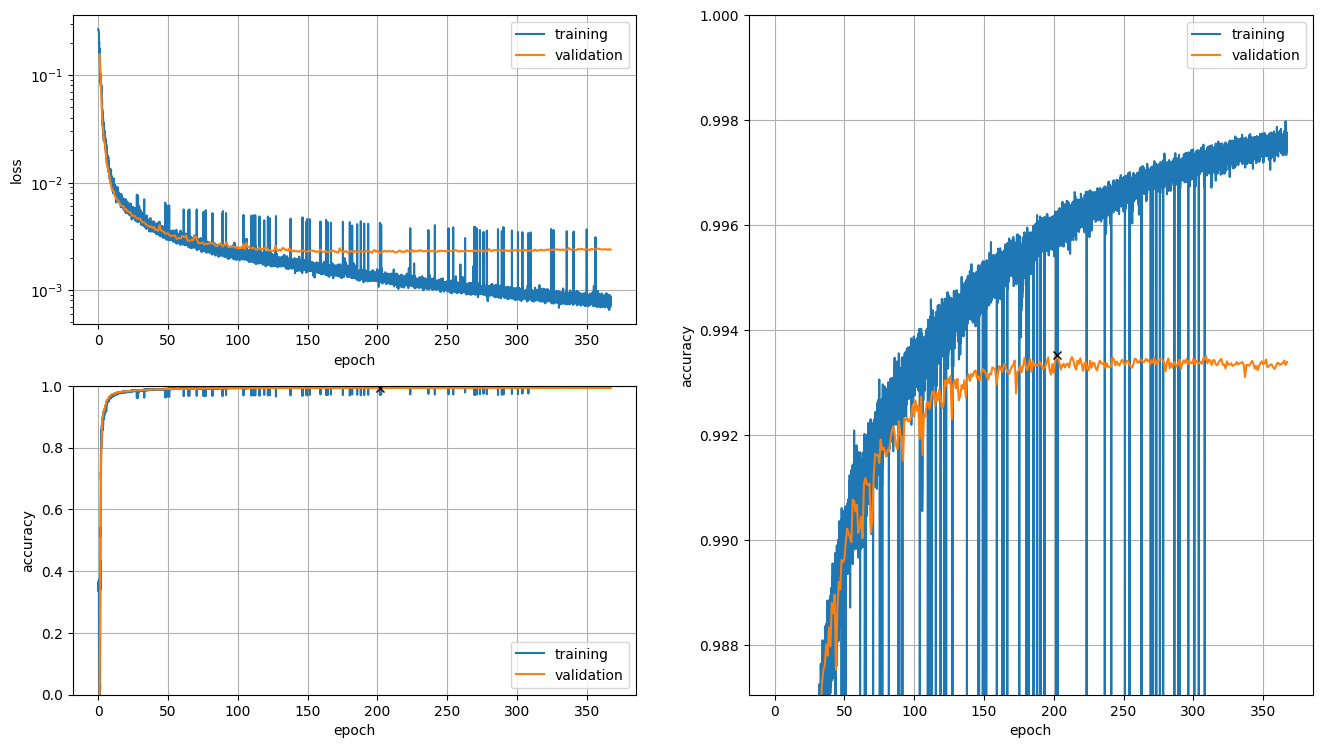

In [16]:
npzfile = np.load('/data/models/carvana_history.npz')
print(npzfile.files)
l_epochs_train = npzfile['l_epochs_train'].tolist()
l_epochs_valid = npzfile['l_epochs_valid'].tolist()
l_loss_train = npzfile['l_loss_train'].tolist()
l_loss_valid = npzfile['l_loss_valid'].tolist()
l_accr_train = npzfile['l_accr_train'].tolist()
l_accr_valid = npzfile['l_accr_valid'].tolist()
l_elapsed = npzfile['l_elapsed'].tolist()

idx_accr_valid_best = np.argmax(l_accr_valid)

fig = plt.figure(figsize=(16, 9), dpi=100)

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ln1t, = ax1.plot(l_epochs_train, l_loss_train, '-', c='tab:blue', label='training')
ln1v, = ax1.plot(l_epochs_valid, l_loss_valid, '-', c='tab:orange', label='validation')
ax1.legend()
ax1.grid(True)
ax1.set_yscale('log')

ax2 = fig.add_subplot(2, 2, 3)
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ln2t, = ax2.plot(l_epochs_train, l_accr_train, '-', c='tab:blue', label='training')
ln2v, = ax2.plot(l_epochs_valid, l_accr_valid, '-', c='tab:orange', label='validation')
ln2x, = ax2.plot(l_epochs_valid[idx_accr_valid_best], l_accr_valid[idx_accr_valid_best], 'kx')
ax2.set_ylim(0., 1.)
ax2.legend()
ax2.grid(True)

ax3 = fig.add_subplot(1, 2, 2)
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ln3t, = ax3.plot(l_epochs_train, l_accr_train, '-', c='tab:blue', label='training')
ln3v, = ax3.plot(l_epochs_valid, l_accr_valid, '-', c='tab:orange', label='validation')
ln3x, = ax3.plot(l_epochs_valid[idx_accr_valid_best], l_accr_valid[idx_accr_valid_best], 'kx')
ax3.set_ylim(1. - 2. * (1. - min(max(l_accr_train), max(l_accr_valid))), 1.)
ax3.legend()
ax3.grid(True)

plt.show()

## Trained model

In [17]:
model = torch.load('/data/models/carvana_model.pt')

/home/nmserver/jupyterhub/.virtualenvs/jupyterhub/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/nmserver/jupyterhub/.virtualenvs/jupyterhub/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/nmserver/jupyterhub/.virtualenvs/jupyterhub/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.

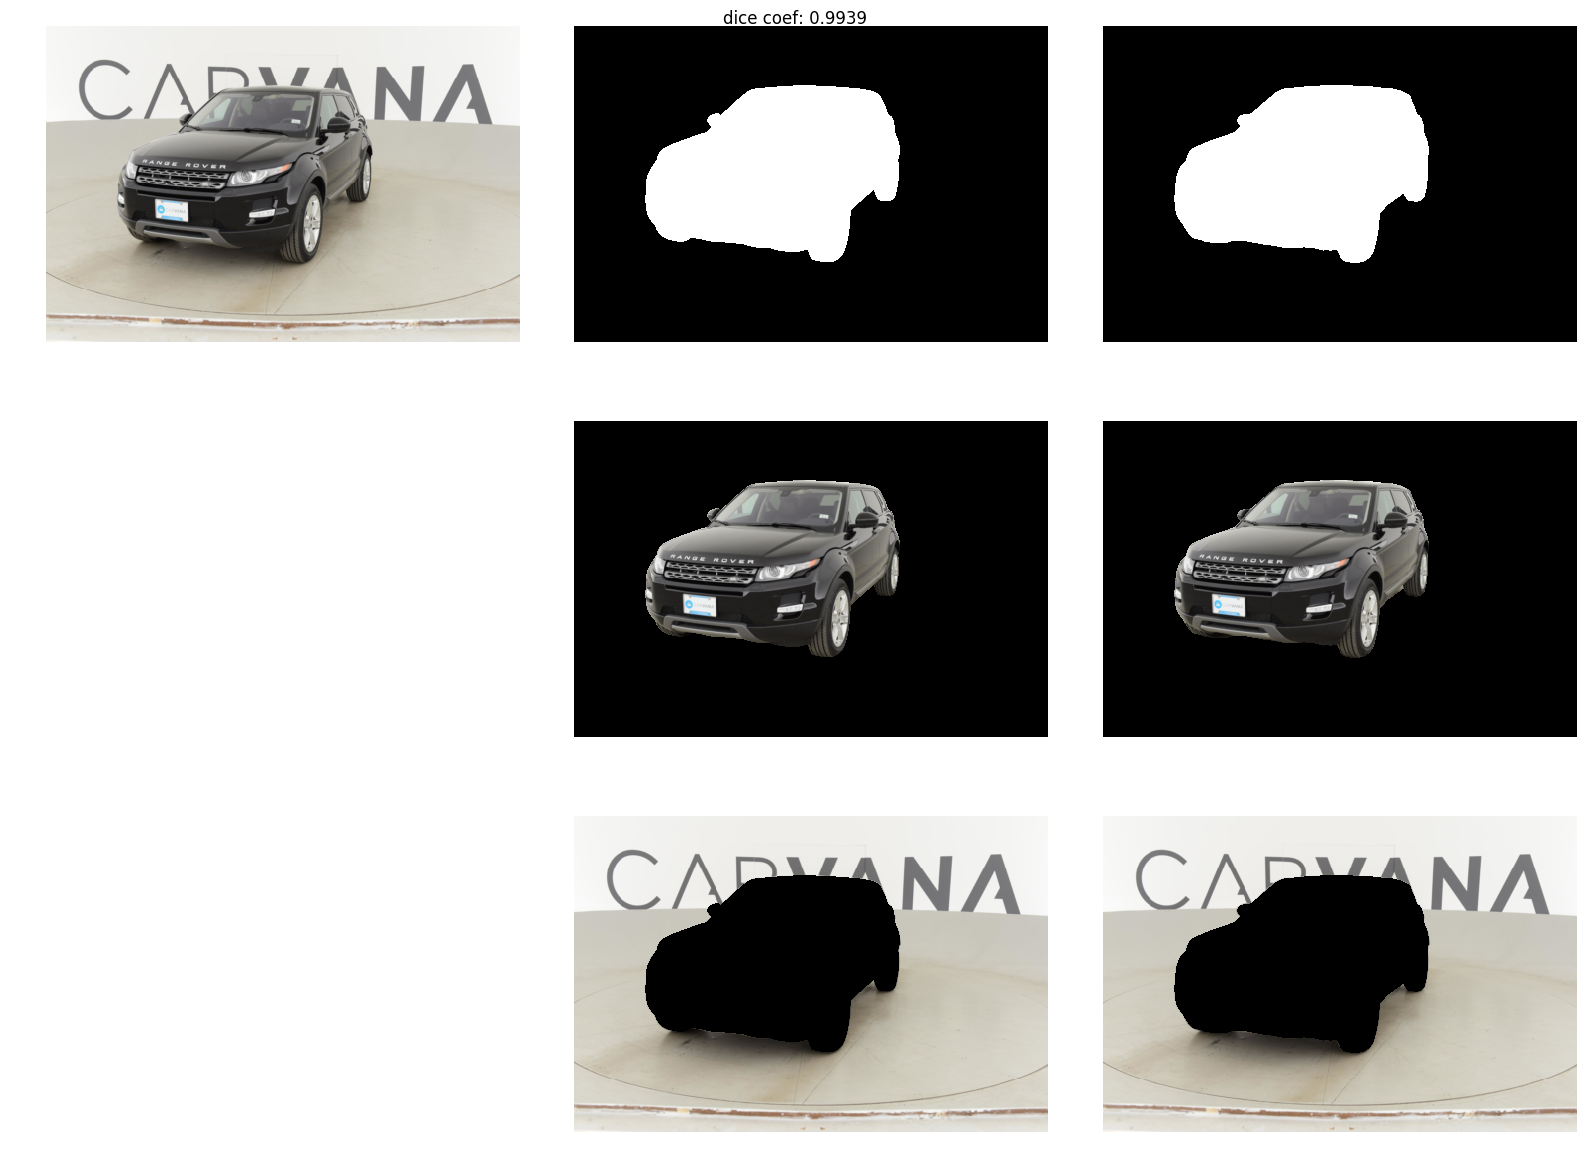

In [18]:
batch_size = 1
dl_test = torch.utils.data.DataLoader(ds_valid, batch_size=batch_size, num_workers=num_workers, shuffle=True)
x, y = next(iter(dl_test))
inp = torch.autograd.Variable(x)
o = torch.round(model.module(inp).data)
yx = y * x
ox = o * x
nyx = (1 - y) * x
nox = (1 - o) * x

fig = plt.figure(figsize=(16, 12), dpi=100)
n_rows = 3
n_axes = 9
for i_sample in range(batch_size):
    fig.suptitle('dice coef: {:.4f}'.format(dice(y, o)))

    ax1 = fig.add_subplot(n_rows * batch_size, 3, 1 + n_axes * i_sample)
    ax1.imshow(x[i_sample].numpy().transpose(1, 2, 0))
    ax1.axis('off')

    ax2 = fig.add_subplot(n_rows * batch_size, 3, 2 + n_axes * i_sample)
    ax2.imshow(y[i_sample].squeeze(0).numpy(), cmap='gray')
    ax2.axis('off')

    ax3 = fig.add_subplot(n_rows * batch_size, 3, 3 + n_axes * i_sample)
    ax3.imshow(o[i_sample].squeeze(0).numpy(), cmap='gray')
    ax3.axis('off')

    ax5 = fig.add_subplot(n_rows * batch_size, 3, 5 + n_axes * i_sample)
    ax5.imshow(yx[i_sample].numpy().transpose(1, 2, 0))
    ax5.axis('off')

    ax6 = fig.add_subplot(n_rows * batch_size, 3, 6 + n_axes * i_sample)
    ax6.imshow(ox[i_sample].numpy().transpose(1, 2, 0))
    ax6.axis('off')

    ax8 = fig.add_subplot(n_rows * batch_size, 3, 8 + n_axes * i_sample)
    ax8.imshow(nyx[i_sample].numpy().transpose(1, 2, 0))
    ax8.axis('off')

    ax9 = fig.add_subplot(n_rows * batch_size, 3, 9 + n_axes * i_sample)
    ax9.imshow(nox[i_sample].numpy().transpose(1, 2, 0))
    ax9.axis('off')

fig.tight_layout()
plt.show()

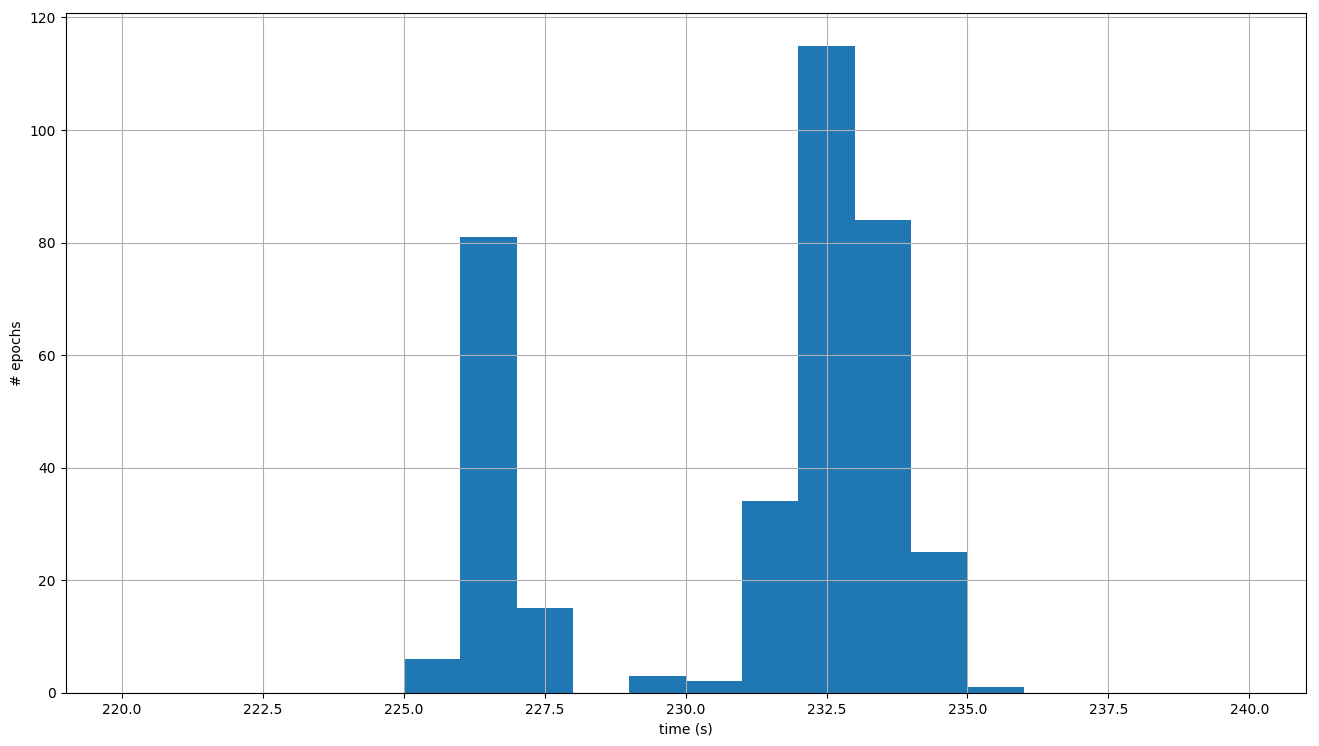

In [19]:
fig = plt.figure(figsize=(16, 9), dpi=100)
plt.hist(l_elapsed, bins=20, range=(220, 240))
plt.xlabel('time (s)')
plt.ylabel('# epochs')
plt.grid(True)
plt.show()